# Vehicle Detection

*Much code adapted from Udacity's Vehicle Detection and Tracking Lesson*

In [1]:
import numpy as np
import cv2
import glob
import time

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from skimage.feature import hog

from scipy.ndimage.measurements import label

from helperfunctions import *

### 1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier (e.g. a Linear SVM classifier)


#### 1.1 Set up helper functions for extracting HOG and colour features

See `helperfunctions.py`

#### 1.2 Prepare data for classifier (extract features)

In [2]:
# Read in cars and notcars
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')


# TODO: Remove
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 500
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

# Check that arrays are not empty
print(cars[0])
print(notcars[0])

vehicles/GTI_Far/image0000.png
non-vehicles/Extras/extra1.png


[array([ 0.01355152,  0.0046978 ,  0.04738626, ...,  0.01939558,
         0.00384331,  0.00969454])]

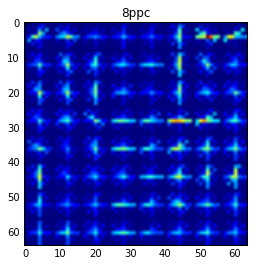

In [3]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 6  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 3 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 24    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG f`eatures on or off
xy_window_size = (64, 64)
xy_overlap_size = (0.5, 0.5)

y_start_stop = [400, 720] # Min and max in y to search in slide_window()
image_file_name = "hogviz/" + str(color_space) + "_ss" + str(spatial_size[0]) + str(spatial_size[1]) + "_hb" + str(hist_bins) + "_TTT_" + "o" + str(orient) \
                    + "_ppc" + str(pix_per_cell) + "_cpb" \
                    + str(cell_per_block) + "_hc" + str(hog_channel) + "_wdw" \
                    #+ str(xy_window_size[0]) + str(xy_window_size[1]) + "_olp" \
                    #+ str(xy_overlap_size[0]) + str(xy_overlap_size[1])
image_title = str(pix_per_cell) + "ppc"
logfilepath = "logs/hogviz_experiments/ppc_exp1.md"

sample_car = [cars[42]]
sample_notcar = [notcars[42]]

extract_features(sample_car, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat,
                        viz=True, viz_only=True, viz_title=image_title, hog_viz_name=image_file_name)

In [4]:
# Extract features
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Normalise input
X = normalise(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 6 orientations 8 pixels per cell and 3 cells per block
Feature vector length: 5832


### Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.

#### 1.3 Train classifier

In [5]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
training_time = round(t2-t, 4)
print(training_time, 'Seconds to train SVC...')
# Check the score of the SVC
svc_score = round(svc.score(X_test, y_test), 8)
print('Test Accuracy of SVC = ', svc_score)
# Check the prediction time for a single sample
t=time.time()

# Log training parameters and results

with open(logfilepath, "a") as f:
    f.write("\n\n" + str(image_file_name))
    f.write("\nParameters:")
    f.write("\ncolor_space: " + str(color_space))
    f.write("\norient: " + str(orient))
    f.write("\npix_per_cell: " + str(pix_per_cell))
    f.write("\ncell_per_block: " + str(cell_per_block))
    f.write("\nhog_channel: " + str(hog_channel))
    f.write("\nspatial_size: " + str(spatial_size))
    f.write("\nhist_bins: " + str(hist_bins))
    f.write("\nspatial_feat: " + str(spatial_feat))
    f.write("\nhist_feat: " + str(hist_feat))
    f.write("\nhog_feat: " + str(hog_feat))
    f.write('\nFeature vector length:' + str(len(X_train[0])))
    f.write("\n" + str(training_time) + 'Seconds to train SVC...')
    f.write('\nTest Accuracy of SVC = ' + str(svc_score))

print("\nParameters:")
print("color_space: ", color_space)
print("orient: ", orient)
print("pix_per_cell: ", pix_per_cell)
print("cell_per_block: ", cell_per_block)
print("hog_channel: ", hog_channel)
print("spatial_size: ", spatial_size)
print("hist_bins: ", hist_bins)
print("spatial_feat: ", spatial_feat)
print("hist_feat: ", hist_feat)
print("hog_feat: ", hog_feat)

0.2604 Seconds to train SVC...
Test Accuracy of SVC =  0.995

Parameters:
color_space:  YCrCb
orient:  6
pix_per_cell:  8
cell_per_block:  3
hog_channel:  ALL
spatial_size:  (16, 16)
hist_bins:  24
spatial_feat:  False
hist_feat:  False
hog_feat:  True


### 2. Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

In [6]:
def draw_on_image(testimage_number):
    # Read in image
    image = mpimg.imread('test_images/test' + str(testimage_number) + '.jpg')
    draw_image = np.copy(image)

    # Rescale data since training data extracted from 
    # .png images (scaled 0 to 1 by mpimg) and image we
    # are searching is .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255
    
    # Normalise image
    # image = normalise(image)
    # print(image, image.shape)
    
    # Get list of windows to search at this stage.
    windows = slide_window(image, x_start_stop=[600, 1280], y_start_stop=y_start_stop, 
                        xy_window=xy_window_size, xy_overlap=xy_overlap_size)

    # Return all the windows the classifier has predicted contain car(s) ('positive windows').
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    # Draw bounding boxes around the windows that the classifier predicted has cars in them
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    # Plot image with bounding boxes drawn.
    plt.title(image_title)
    plt.imshow(window_img)
    plt.savefig(image_file_name + "_window_test" + str(testimage_number) + ".png")

In [29]:
windows = slide_window(image, x_start_stop=[600, 1280], y_start_stop=y_start_stop, 
                        xy_window=xy_window_size, xy_overlap=xy_overlap_size)

In [7]:
print("y bounds for region we search using the sliding window technique: ", 
      y_start_stop)

y bounds for region we search using the sliding window technique:  [400, 720]


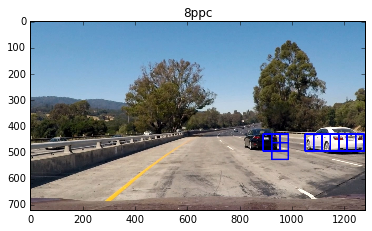

In [8]:
draw_on_image(1)

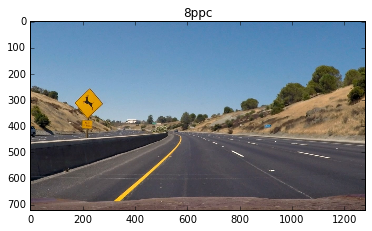

In [9]:
draw_on_image(2)

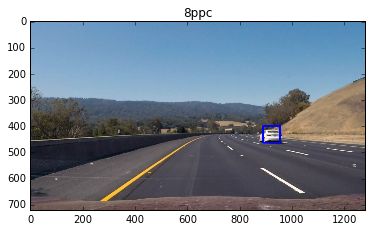

In [10]:
draw_on_image(3)

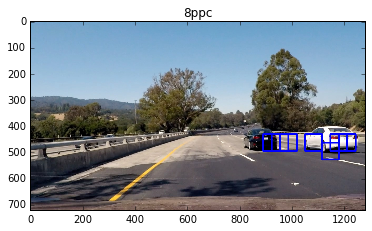

In [11]:
draw_on_image(4)

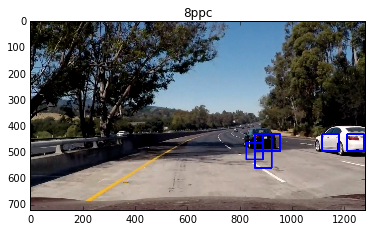

In [12]:
draw_on_image(5)

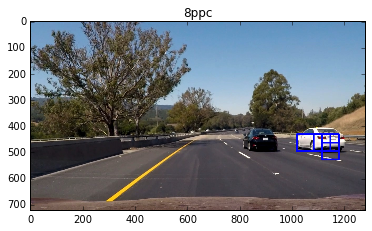

In [13]:
draw_on_image(6)

### 4. Run your pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

In [31]:
def add_bboxes(input_image, windows, classifier, scaler, draw=True, bboxes_only=False):
    """Adds bounding boxes from `input_image` (one array of arrays) to
    the global variable `bboxes_list`'.
    If `draw` is True, returns image overlaid with bounding boxes.
    """
    global bboxes_list
    
    # Normalise image
    # input_image = normalise(input_image)
    
    hot_windows = search_windows(input_image, windows, classifier, scaler, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)
    print("Hot windows: ", hot_windows)
    bboxes_list.append(hot_windows)
    if draw == True:
        draw_image = np.copy(input_image)
        window_img = draw_boxes(input_image, hot_windows, color=(0, 0, 255), thick=6)
        return window_img

In [24]:
def add_bboxes_to_list(image):
    """Adds bounding boxes in `image` to global `bboxes_list`.
    Returns image with bounding boxes drawn.
    """
    return add_bboxes(image, windows, svc, X_scaler)

[MoviePy reference](https://zulko.github.io/moviepy/crash_course/crash_course.html)

#### Combine multiple detections and remove false positives

In [25]:
def add_heat(heatmap, box_list):
    """Returns `heatmap` with bounding boxes in `bbox_list` added to it.
    `bbox_list` is an array of boxes.

    This function should be applied per frame.
    """
    # Iterate through list of bboxes
    for box in box_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

### 5. Estimate a bounding box for vehicles detected.

In [26]:
# Implement using a queue of length `recent_frames_used`.
# MVP can just go through the array each time cause I'm lazy

def draw_filtered_bboxes(image, all_bboxes, recent_frames_used=20, threshold=5): 
    """`all_bboxes` is an array of arrays of bboxes.
    Each element represents a frame. Each element is an array of bboxes found in
    that frame."""
    
    # Add bounding boxes from this frame
    add_bboxes(image, windows, svc, X_scaler, draw=False)
    
    if len(all_bboxes) < recent_frames_used + 1:
        recent_frames_used = len(all_bboxes) - 1
    
    frame_heatmap = np.zeros_like(image[:,:,0])
    
    for boxlist in all_bboxes[-recent_frames_used:]:
        frame_heatmap = add_heat(frame_heatmap, boxlist)
    
    # Apply threshold
    frame_heatmap = apply_threshold(frame_heatmap, threshold)
    
    labels = label(frame_heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    plt.imshow(draw_img)
    return draw_img

In [27]:
def process_image(image):
    global bboxes_list    
    
    return draw_filtered_bboxes(image, bboxes_list)

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

bboxes_list = []

video = VideoFileClip("project_video.mp4")
project_clip = video.fl_image(process_image) #NOTE: this function expects color images!!
video_output = "output_v3.mp4"
%time project_clip.write_videofile(video_output, audio=False)

print("Bounding boxes: ", bboxes_list)

Hot windows:  []
[MoviePy] >>>> Building video output_v3.mp4
[MoviePy] Writing video output_v3.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<13:58,  1.50it/s]

Hot windows:  []




  0%|          | 2/1261 [00:01<14:11,  1.48it/s]

Hot windows:  []




  0%|          | 3/1261 [00:02<15:09,  1.38it/s]

Hot windows:  []




  0%|          | 4/1261 [00:02<14:43,  1.42it/s]

Hot windows:  []




  0%|          | 5/1261 [00:03<15:06,  1.39it/s]

Hot windows:  []




  0%|          | 6/1261 [00:04<14:36,  1.43it/s]

Hot windows:  []




  1%|          | 7/1261 [00:04<14:12,  1.47it/s]

Hot windows:  []




  1%|          | 8/1261 [00:05<13:54,  1.50it/s]

Hot windows:  []




  1%|          | 9/1261 [00:06<13:40,  1.53it/s]

Hot windows:  []




  1%|          | 10/1261 [00:06<13:46,  1.51it/s]

Hot windows:  []




  1%|          | 11/1261 [00:07<13:37,  1.53it/s]

Hot windows:  []




  1%|          | 12/1261 [00:08<13:28,  1.54it/s]

Hot windows:  []




  1%|          | 13/1261 [00:08<13:50,  1.50it/s]

Hot windows:  []




  1%|          | 14/1261 [00:09<13:33,  1.53it/s]

Hot windows:  []




  1%|          | 15/1261 [00:10<13:22,  1.55it/s]

Hot windows:  []




  1%|▏         | 16/1261 [00:10<13:07,  1.58it/s]

Hot windows:  []




  1%|▏         | 17/1261 [00:11<13:23,  1.55it/s]

Hot windows:  []




  1%|▏         | 18/1261 [00:12<13:36,  1.52it/s]

Hot windows:  []




  2%|▏         | 19/1261 [00:12<13:20,  1.55it/s]

Hot windows:  []




  2%|▏         | 20/1261 [00:13<13:32,  1.53it/s]

Hot windows:  []




  2%|▏         | 21/1261 [00:13<13:21,  1.55it/s]

Hot windows:  [((952, 400), (1016, 464))]




  2%|▏         | 22/1261 [00:14<13:00,  1.59it/s]

Hot windows:  []




  2%|▏         | 23/1261 [00:15<12:50,  1.61it/s]

Hot windows:  []




  2%|▏         | 24/1261 [00:15<12:54,  1.60it/s]

Hot windows:  []




  2%|▏         | 25/1261 [00:16<12:48,  1.61it/s]

Hot windows:  [((984, 400), (1048, 464))]




  2%|▏         | 26/1261 [00:17<12:43,  1.62it/s]

Hot windows:  []




  2%|▏         | 27/1261 [00:17<12:49,  1.60it/s]

Hot windows:  []




  2%|▏         | 28/1261 [00:18<12:55,  1.59it/s]

Hot windows:  []




  2%|▏         | 29/1261 [00:18<12:50,  1.60it/s]

Hot windows:  []




  2%|▏         | 30/1261 [00:19<12:43,  1.61it/s]

Hot windows:  []




  2%|▏         | 31/1261 [00:20<12:54,  1.59it/s]

Hot windows:  []




  3%|▎         | 32/1261 [00:20<12:55,  1.59it/s]

Hot windows:  []




  3%|▎         | 33/1261 [00:21<12:34,  1.63it/s]

Hot windows:  []




  3%|▎         | 34/1261 [00:21<12:20,  1.66it/s]

Hot windows:  []




  3%|▎         | 35/1261 [00:22<12:09,  1.68it/s]

Hot windows:  []




  3%|▎         | 36/1261 [00:23<12:00,  1.70it/s]

Hot windows:  []




  3%|▎         | 37/1261 [00:23<11:55,  1.71it/s]

Hot windows:  []




  3%|▎         | 38/1261 [00:24<11:51,  1.72it/s]

Hot windows:  []




  3%|▎         | 39/1261 [00:24<11:52,  1.72it/s]

Hot windows:  [((1080, 400), (1144, 464))]




  3%|▎         | 40/1261 [00:25<12:09,  1.67it/s]

Hot windows:  []




  3%|▎         | 41/1261 [00:26<12:11,  1.67it/s]

Hot windows:  []




  3%|▎         | 42/1261 [00:26<12:18,  1.65it/s]

Hot windows:  []




  3%|▎         | 43/1261 [00:27<12:36,  1.61it/s]

Hot windows:  []




  3%|▎         | 44/1261 [00:28<12:55,  1.57it/s]

Hot windows:  []




  4%|▎         | 45/1261 [00:28<12:57,  1.56it/s]

Hot windows:  []




  4%|▎         | 46/1261 [00:29<13:05,  1.55it/s]

Hot windows:  []




  4%|▎         | 47/1261 [00:29<12:46,  1.58it/s]

Hot windows:  []




  4%|▍         | 48/1261 [00:30<13:01,  1.55it/s]

Hot windows:  []




  4%|▍         | 49/1261 [00:31<13:25,  1.51it/s]

Hot windows:  []




  4%|▍         | 50/1261 [00:32<13:39,  1.48it/s]

Hot windows:  []




  4%|▍         | 51/1261 [00:32<13:27,  1.50it/s]

Hot windows:  []




  4%|▍         | 52/1261 [00:33<13:03,  1.54it/s]

Hot windows:  []




  4%|▍         | 53/1261 [00:33<12:47,  1.57it/s]

Hot windows:  []




  4%|▍         | 54/1261 [00:34<12:40,  1.59it/s]

Hot windows:  []




  4%|▍         | 55/1261 [00:35<12:35,  1.60it/s]

Hot windows:  []




  4%|▍         | 56/1261 [00:35<12:41,  1.58it/s]

Hot windows:  []




  5%|▍         | 57/1261 [00:36<13:02,  1.54it/s]

Hot windows:  []




  5%|▍         | 58/1261 [00:37<12:48,  1.56it/s]

Hot windows:  []




  5%|▍         | 59/1261 [00:37<12:39,  1.58it/s]

Hot windows:  [((1112, 432), (1176, 496))]




  5%|▍         | 60/1261 [00:38<12:26,  1.61it/s]

Hot windows:  []




  5%|▍         | 61/1261 [00:38<12:30,  1.60it/s]

Hot windows:  []




  5%|▍         | 62/1261 [00:39<12:25,  1.61it/s]

Hot windows:  []




  5%|▍         | 63/1261 [00:40<12:21,  1.62it/s]

Hot windows:  []




  5%|▌         | 64/1261 [00:40<12:17,  1.62it/s]

Hot windows:  []




  5%|▌         | 65/1261 [00:41<12:12,  1.63it/s]

Hot windows:  []




  5%|▌         | 66/1261 [00:41<12:10,  1.64it/s]

Hot windows:  []




  5%|▌         | 67/1261 [00:42<12:08,  1.64it/s]

Hot windows:  []




  5%|▌         | 68/1261 [00:43<12:07,  1.64it/s]

Hot windows:  []




  5%|▌         | 69/1261 [00:43<12:06,  1.64it/s]

Hot windows:  []




  6%|▌         | 70/1261 [00:44<12:05,  1.64it/s]

Hot windows:  []




  6%|▌         | 71/1261 [00:44<12:07,  1.64it/s]

Hot windows:  []




  6%|▌         | 72/1261 [00:45<12:08,  1.63it/s]

Hot windows:  []




  6%|▌         | 73/1261 [00:46<12:10,  1.63it/s]

Hot windows:  []




  6%|▌         | 74/1261 [00:46<12:10,  1.62it/s]

Hot windows:  []




  6%|▌         | 75/1261 [00:47<12:13,  1.62it/s]

Hot windows:  []




  6%|▌         | 76/1261 [00:48<12:11,  1.62it/s]

Hot windows:  []




  6%|▌         | 77/1261 [00:48<12:08,  1.62it/s]

Hot windows:  []




  6%|▌         | 78/1261 [00:49<12:04,  1.63it/s]

Hot windows:  []




  6%|▋         | 79/1261 [00:49<12:04,  1.63it/s]

Hot windows:  []




  6%|▋         | 80/1261 [00:50<12:06,  1.63it/s]

Hot windows:  []




  6%|▋         | 81/1261 [00:51<11:59,  1.64it/s]

Hot windows:  []




  7%|▋         | 82/1261 [00:51<11:59,  1.64it/s]

Hot windows:  []




  7%|▋         | 83/1261 [00:52<11:59,  1.64it/s]

Hot windows:  []




  7%|▋         | 84/1261 [00:52<11:55,  1.64it/s]

Hot windows:  []




  7%|▋         | 85/1261 [00:53<11:59,  1.64it/s]

Hot windows:  []




  7%|▋         | 86/1261 [00:54<11:53,  1.65it/s]

Hot windows:  []




  7%|▋         | 87/1261 [00:54<11:50,  1.65it/s]

Hot windows:  []




  7%|▋         | 88/1261 [00:55<11:51,  1.65it/s]

Hot windows:  []




  7%|▋         | 89/1261 [00:55<11:48,  1.65it/s]

Hot windows:  []




  7%|▋         | 90/1261 [00:56<11:55,  1.64it/s]

Hot windows:  []




  7%|▋         | 91/1261 [00:57<12:00,  1.62it/s]

Hot windows:  []




  7%|▋         | 92/1261 [00:57<11:56,  1.63it/s]

Hot windows:  []




  7%|▋         | 93/1261 [00:58<11:50,  1.64it/s]

Hot windows:  []




  7%|▋         | 94/1261 [00:59<11:44,  1.66it/s]

Hot windows:  [((984, 400), (1048, 464))]




  8%|▊         | 95/1261 [00:59<11:42,  1.66it/s]

Hot windows:  [((984, 400), (1048, 464))]




  8%|▊         | 96/1261 [01:00<11:38,  1.67it/s]

Hot windows:  []




  8%|▊         | 97/1261 [01:00<11:42,  1.66it/s]

Hot windows:  []




  8%|▊         | 98/1261 [01:01<11:40,  1.66it/s]

Hot windows:  [((952, 400), (1016, 464))]




  8%|▊         | 99/1261 [01:02<11:36,  1.67it/s]

Hot windows:  []




  8%|▊         | 100/1261 [01:02<11:35,  1.67it/s]

Hot windows:  []




  8%|▊         | 101/1261 [01:03<11:34,  1.67it/s]

Hot windows:  []




  8%|▊         | 102/1261 [01:03<11:34,  1.67it/s]

Hot windows:  []




  8%|▊         | 103/1261 [01:04<11:34,  1.67it/s]

Hot windows:  [((984, 400), (1048, 464))]




  8%|▊         | 104/1261 [01:05<11:32,  1.67it/s]

Hot windows:  []




  8%|▊         | 105/1261 [01:05<11:31,  1.67it/s]

Hot windows:  []




  8%|▊         | 106/1261 [01:06<11:30,  1.67it/s]

Hot windows:  []




  8%|▊         | 107/1261 [01:06<11:33,  1.66it/s]

Hot windows:  [((1048, 400), (1112, 464))]




  9%|▊         | 108/1261 [01:07<11:28,  1.67it/s]

Hot windows:  [((1016, 400), (1080, 464))]




  9%|▊         | 109/1261 [01:08<11:32,  1.66it/s]

Hot windows:  []




  9%|▊         | 110/1261 [01:08<11:41,  1.64it/s]

Hot windows:  []




  9%|▉         | 111/1261 [01:09<11:35,  1.65it/s]

Hot windows:  []




  9%|▉         | 112/1261 [01:09<11:31,  1.66it/s]

Hot windows:  [((1048, 400), (1112, 464))]




  9%|▉         | 113/1261 [01:10<11:28,  1.67it/s]

Hot windows:  []




  9%|▉         | 114/1261 [01:11<11:26,  1.67it/s]

Hot windows:  []




  9%|▉         | 115/1261 [01:11<11:23,  1.68it/s]

Hot windows:  []




  9%|▉         | 116/1261 [01:12<11:18,  1.69it/s]

Hot windows:  [((1208, 464), (1272, 528))]




  9%|▉         | 117/1261 [01:12<11:18,  1.68it/s]

Hot windows:  []




  9%|▉         | 118/1261 [01:13<11:26,  1.67it/s]

Hot windows:  []




  9%|▉         | 119/1261 [01:14<11:20,  1.68it/s]

Hot windows:  []




 10%|▉         | 120/1261 [01:14<11:21,  1.67it/s]

Hot windows:  []




 10%|▉         | 121/1261 [01:15<11:19,  1.68it/s]

Hot windows:  []




 10%|▉         | 122/1261 [01:15<11:16,  1.68it/s]

Hot windows:  [((1144, 400), (1208, 464))]




 10%|▉         | 123/1261 [01:16<11:18,  1.68it/s]

Hot windows:  []




 10%|▉         | 124/1261 [01:16<11:16,  1.68it/s]

Hot windows:  []




 10%|▉         | 125/1261 [01:17<11:16,  1.68it/s]

Hot windows:  []




 10%|▉         | 126/1261 [01:18<11:12,  1.69it/s]

Hot windows:  [((1176, 464), (1240, 528))]




 10%|█         | 127/1261 [01:18<11:07,  1.70it/s]

Hot windows:  []




 10%|█         | 128/1261 [01:19<11:06,  1.70it/s]

Hot windows:  []




 10%|█         | 129/1261 [01:19<11:04,  1.70it/s]

Hot windows:  []




 10%|█         | 130/1261 [01:20<11:05,  1.70it/s]

Hot windows:  []




 10%|█         | 131/1261 [01:21<11:05,  1.70it/s]

Hot windows:  []




 10%|█         | 132/1261 [01:21<11:09,  1.69it/s]

Hot windows:  []




 11%|█         | 133/1261 [01:22<11:10,  1.68it/s]

Hot windows:  []




 11%|█         | 134/1261 [01:22<11:06,  1.69it/s]

Hot windows:  []




 11%|█         | 135/1261 [01:23<11:07,  1.69it/s]

Hot windows:  []




 11%|█         | 136/1261 [01:24<11:07,  1.68it/s]

Hot windows:  []




 11%|█         | 137/1261 [01:24<11:05,  1.69it/s]

Hot windows:  []




 11%|█         | 138/1261 [01:25<11:05,  1.69it/s]

Hot windows:  []




 11%|█         | 139/1261 [01:25<11:07,  1.68it/s]

Hot windows:  []




 11%|█         | 140/1261 [01:26<11:12,  1.67it/s]

Hot windows:  []




 11%|█         | 141/1261 [01:27<11:10,  1.67it/s]

Hot windows:  []




 11%|█▏        | 142/1261 [01:27<11:18,  1.65it/s]

Hot windows:  []




 11%|█▏        | 143/1261 [01:28<12:14,  1.52it/s]

Hot windows:  []




 11%|█▏        | 144/1261 [01:29<12:29,  1.49it/s]

Hot windows:  []




 11%|█▏        | 145/1261 [01:29<12:49,  1.45it/s]

Hot windows:  []




 12%|█▏        | 146/1261 [01:30<13:12,  1.41it/s]

Hot windows:  [((1208, 432), (1272, 496))]




 12%|█▏        | 147/1261 [01:31<13:11,  1.41it/s]

Hot windows:  [((1208, 432), (1272, 496))]




 12%|█▏        | 148/1261 [01:32<13:03,  1.42it/s]

Hot windows:  [((1208, 432), (1272, 496))]




 12%|█▏        | 149/1261 [01:32<13:10,  1.41it/s]

Hot windows:  [((920, 432), (984, 496)), ((1208, 432), (1272, 496))]




 12%|█▏        | 150/1261 [01:33<12:52,  1.44it/s]

Hot windows:  []




 12%|█▏        | 151/1261 [01:34<12:36,  1.47it/s]

Hot windows:  []




 12%|█▏        | 152/1261 [01:34<12:26,  1.48it/s]

Hot windows:  [((1176, 464), (1240, 528))]




 12%|█▏        | 153/1261 [01:35<12:26,  1.48it/s]

Hot windows:  [((1176, 464), (1240, 528))]




 12%|█▏        | 154/1261 [01:36<12:19,  1.50it/s]

Hot windows:  []




 12%|█▏        | 155/1261 [01:36<12:14,  1.51it/s]

Hot windows:  []




 12%|█▏        | 156/1261 [01:37<12:09,  1.51it/s]

Hot windows:  []




 12%|█▏        | 157/1261 [01:38<11:55,  1.54it/s]

Hot windows:  [((1176, 432), (1240, 496))]




 13%|█▎        | 158/1261 [01:38<11:52,  1.55it/s]

Hot windows:  [((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((1208, 464), (1272, 528))]




 13%|█▎        | 159/1261 [01:39<12:43,  1.44it/s]

Hot windows:  [((1176, 432), (1240, 496))]




 13%|█▎        | 160/1261 [01:40<12:16,  1.49it/s]

Hot windows:  [((1176, 432), (1240, 496))]




 13%|█▎        | 161/1261 [01:40<12:21,  1.48it/s]

Hot windows:  [((1176, 432), (1240, 496))]




 13%|█▎        | 162/1261 [01:41<12:19,  1.49it/s]

Hot windows:  [((1176, 432), (1240, 496))]




 13%|█▎        | 163/1261 [01:42<12:39,  1.45it/s]

Hot windows:  []




 13%|█▎        | 164/1261 [01:42<13:03,  1.40it/s]

Hot windows:  []




 13%|█▎        | 165/1261 [01:43<13:01,  1.40it/s]

Hot windows:  [((1208, 400), (1272, 464))]




 13%|█▎        | 166/1261 [01:44<12:55,  1.41it/s]

Hot windows:  [((1208, 400), (1272, 464))]




 13%|█▎        | 167/1261 [01:45<12:46,  1.43it/s]

Hot windows:  [((1208, 400), (1272, 464)), ((1176, 432), (1240, 496)), ((1176, 464), (1240, 528))]




 13%|█▎        | 168/1261 [01:45<12:14,  1.49it/s]

Hot windows:  [((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1176, 464), (1240, 528))]




 13%|█▎        | 169/1261 [01:46<11:59,  1.52it/s]

Hot windows:  [((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1176, 464), (1240, 528))]




 13%|█▎        | 170/1261 [01:47<12:46,  1.42it/s]

Hot windows:  [((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1176, 464), (1240, 528))]




 14%|█▎        | 171/1261 [01:47<12:32,  1.45it/s]

Hot windows:  [((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1176, 464), (1240, 528))]




 14%|█▎        | 172/1261 [01:48<12:08,  1.50it/s]

Hot windows:  [((1144, 432), (1208, 496)), ((1176, 432), (1240, 496))]




 14%|█▎        | 173/1261 [01:48<11:54,  1.52it/s]

Hot windows:  [((1144, 432), (1208, 496))]




 14%|█▍        | 174/1261 [01:49<12:06,  1.50it/s]

Hot windows:  [((1144, 432), (1208, 496))]




 14%|█▍        | 175/1261 [01:50<12:07,  1.49it/s]

Hot windows:  [((1144, 432), (1208, 496))]




 14%|█▍        | 176/1261 [01:51<12:17,  1.47it/s]

Hot windows:  [((1176, 400), (1240, 464))]




 14%|█▍        | 177/1261 [01:51<12:07,  1.49it/s]

Hot windows:  [((1176, 400), (1240, 464)), ((1144, 432), (1208, 496))]




 14%|█▍        | 178/1261 [01:52<12:01,  1.50it/s]

Hot windows:  [((1176, 400), (1240, 464)), ((1144, 432), (1208, 496)), ((1112, 464), (1176, 528))]




 14%|█▍        | 179/1261 [01:53<12:03,  1.49it/s]

Hot windows:  [((1176, 400), (1240, 464)), ((1144, 432), (1208, 496)), ((1112, 464), (1176, 528))]




 14%|█▍        | 180/1261 [01:53<12:00,  1.50it/s]

Hot windows:  [((1144, 432), (1208, 496)), ((1112, 464), (1176, 528))]




 14%|█▍        | 181/1261 [01:54<11:55,  1.51it/s]

Hot windows:  [((1144, 432), (1208, 496)), ((1144, 464), (1208, 528))]




 14%|█▍        | 182/1261 [01:54<11:37,  1.55it/s]

Hot windows:  [((1144, 432), (1208, 496))]




 15%|█▍        | 183/1261 [01:55<11:38,  1.54it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((1144, 464), (1208, 528))]




 15%|█▍        | 184/1261 [01:56<11:38,  1.54it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((1144, 464), (1208, 528))]




 15%|█▍        | 185/1261 [01:56<11:42,  1.53it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((1144, 464), (1208, 528))]




 15%|█▍        | 186/1261 [01:57<11:52,  1.51it/s]

Hot windows:  [((1112, 432), (1176, 496))]




 15%|█▍        | 187/1261 [01:58<11:48,  1.51it/s]

Hot windows:  [((1112, 432), (1176, 496))]




 15%|█▍        | 188/1261 [01:58<11:49,  1.51it/s]

Hot windows:  [((1112, 432), (1176, 496))]




 15%|█▍        | 189/1261 [01:59<11:57,  1.49it/s]

Hot windows:  [((1112, 432), (1176, 496))]




 15%|█▌        | 190/1261 [02:00<11:52,  1.50it/s]

Hot windows:  [((1112, 432), (1176, 496))]




 15%|█▌        | 191/1261 [02:00<12:01,  1.48it/s]

Hot windows:  [((1112, 432), (1176, 496))]




 15%|█▌        | 192/1261 [02:01<12:06,  1.47it/s]

Hot windows:  [((1144, 400), (1208, 464)), ((1112, 432), (1176, 496)), ((1208, 432), (1272, 496))]




 15%|█▌        | 193/1261 [02:02<12:42,  1.40it/s]

Hot windows:  [((1144, 400), (1208, 464)), ((1112, 432), (1176, 496)), ((1208, 432), (1272, 496))]




 15%|█▌        | 194/1261 [02:03<12:56,  1.37it/s]

Hot windows:  [((1144, 400), (1208, 464)), ((1112, 432), (1176, 496)), ((1208, 432), (1272, 496))]




 15%|█▌        | 195/1261 [02:03<12:51,  1.38it/s]

Hot windows:  [((1144, 400), (1208, 464)), ((1112, 432), (1176, 496)), ((1208, 432), (1272, 496))]




 16%|█▌        | 196/1261 [02:04<12:37,  1.41it/s]

Hot windows:  [((1144, 400), (1208, 464)), ((1112, 432), (1176, 496)), ((1208, 432), (1272, 496))]




 16%|█▌        | 197/1261 [02:05<12:15,  1.45it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496))]




 16%|█▌        | 198/1261 [02:05<12:01,  1.47it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496))]




 16%|█▌        | 199/1261 [02:06<12:05,  1.46it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496))]




 16%|█▌        | 200/1261 [02:07<11:57,  1.48it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496))]




 16%|█▌        | 201/1261 [02:07<12:01,  1.47it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496))]




 16%|█▌        | 202/1261 [02:08<12:05,  1.46it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496))]




 16%|█▌        | 203/1261 [02:09<11:55,  1.48it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((1080, 464), (1144, 528)), ((1112, 464), (1176, 528))]




 16%|█▌        | 204/1261 [02:09<11:53,  1.48it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((1080, 464), (1144, 528)), ((1112, 464), (1176, 528))]




 16%|█▋        | 205/1261 [02:10<11:49,  1.49it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((1112, 464), (1176, 528)), ((1176, 464), (1240, 528))]




 16%|█▋        | 206/1261 [02:11<11:39,  1.51it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((1176, 464), (1240, 528))]




 16%|█▋        | 207/1261 [02:11<11:40,  1.50it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((1176, 464), (1240, 528))]




 16%|█▋        | 208/1261 [02:12<11:32,  1.52it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1176, 464), (1240, 528))]




 17%|█▋        | 209/1261 [02:13<11:32,  1.52it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((1176, 464), (1240, 528))]




 17%|█▋        | 210/1261 [02:13<11:30,  1.52it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((1176, 464), (1240, 528))]




 17%|█▋        | 211/1261 [02:14<11:27,  1.53it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1208, 432), (1272, 496)), ((1176, 464), (1240, 528))]




 17%|█▋        | 212/1261 [02:15<11:24,  1.53it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496))]




 17%|█▋        | 213/1261 [02:15<11:12,  1.56it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496))]




 17%|█▋        | 214/1261 [02:16<11:12,  1.56it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496))]




 17%|█▋        | 215/1261 [02:17<11:09,  1.56it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496))]




 17%|█▋        | 216/1261 [02:17<11:01,  1.58it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496))]




 17%|█▋        | 217/1261 [02:18<10:50,  1.60it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496))]




 17%|█▋        | 218/1261 [02:18<10:42,  1.62it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496))]




 17%|█▋        | 219/1261 [02:19<10:40,  1.63it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496))]




 17%|█▋        | 220/1261 [02:20<10:36,  1.64it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496))]




 18%|█▊        | 221/1261 [02:20<10:34,  1.64it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496))]




 18%|█▊        | 222/1261 [02:21<10:32,  1.64it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496))]




 18%|█▊        | 223/1261 [02:21<10:25,  1.66it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496))]




 18%|█▊        | 224/1261 [02:22<10:23,  1.66it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496))]




 18%|█▊        | 225/1261 [02:23<10:18,  1.68it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496))]




 18%|█▊        | 226/1261 [02:23<10:27,  1.65it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496))]




 18%|█▊        | 227/1261 [02:24<10:30,  1.64it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1080, 464), (1144, 528))]




 18%|█▊        | 228/1261 [02:24<10:20,  1.66it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1080, 464), (1144, 528))]




 18%|█▊        | 229/1261 [02:25<10:15,  1.68it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1080, 464), (1144, 528))]




 18%|█▊        | 230/1261 [02:26<10:17,  1.67it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496))]




 18%|█▊        | 231/1261 [02:26<10:21,  1.66it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]




 18%|█▊        | 232/1261 [02:27<10:29,  1.64it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496))]




 18%|█▊        | 233/1261 [02:27<10:33,  1.62it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1144, 464), (1208, 528))]




 19%|█▊        | 234/1261 [02:28<10:33,  1.62it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1144, 464), (1208, 528))]




 19%|█▊        | 235/1261 [02:29<10:36,  1.61it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1144, 464), (1208, 528))]




 19%|█▊        | 236/1261 [02:29<10:35,  1.61it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1144, 464), (1208, 528))]




 19%|█▉        | 237/1261 [02:30<10:30,  1.62it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496)), ((1144, 464), (1208, 528))]




 19%|█▉        | 238/1261 [02:31<10:24,  1.64it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1144, 432), (1208, 496)), ((1048, 464), (1112, 528))]




 19%|█▉        | 239/1261 [02:31<10:33,  1.61it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1144, 432), (1208, 496))]




 19%|█▉        | 240/1261 [02:32<10:31,  1.62it/s]

Hot windows:  [((1144, 432), (1208, 496))]




 19%|█▉        | 241/1261 [02:32<10:36,  1.60it/s]

Hot windows:  [((1144, 432), (1208, 496))]




 19%|█▉        | 242/1261 [02:33<10:32,  1.61it/s]

Hot windows:  [((1144, 432), (1208, 496))]




 19%|█▉        | 243/1261 [02:34<10:35,  1.60it/s]

Hot windows:  [((1144, 432), (1208, 496))]




 19%|█▉        | 244/1261 [02:34<10:28,  1.62it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496))]




 19%|█▉        | 245/1261 [02:35<10:22,  1.63it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496))]




 20%|█▉        | 246/1261 [02:35<10:19,  1.64it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496))]




 20%|█▉        | 247/1261 [02:36<10:15,  1.65it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1048, 432), (1112, 496)), ((1144, 432), (1208, 496))]




 20%|█▉        | 248/1261 [02:37<10:12,  1.65it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1048, 432), (1112, 496)), ((1144, 432), (1208, 496))]




 20%|█▉        | 249/1261 [02:37<10:06,  1.67it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496))]




 20%|█▉        | 250/1261 [02:38<10:07,  1.67it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1048, 464), (1112, 528))]




 20%|█▉        | 251/1261 [02:39<10:14,  1.64it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1048, 464), (1112, 528))]




 20%|█▉        | 252/1261 [02:39<10:22,  1.62it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496))]




 20%|██        | 253/1261 [02:40<10:27,  1.61it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496))]




 20%|██        | 254/1261 [02:40<10:20,  1.62it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496))]




 20%|██        | 255/1261 [02:41<10:23,  1.61it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496))]




 20%|██        | 256/1261 [02:42<10:28,  1.60it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496))]




 20%|██        | 257/1261 [02:42<10:30,  1.59it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496))]




 20%|██        | 258/1261 [02:43<10:34,  1.58it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496))]




 21%|██        | 259/1261 [02:44<10:32,  1.58it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496))]




 21%|██        | 260/1261 [02:44<10:20,  1.61it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496))]




 21%|██        | 261/1261 [02:45<10:17,  1.62it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496))]




 21%|██        | 262/1261 [02:45<10:31,  1.58it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496))]




 21%|██        | 263/1261 [02:46<10:27,  1.59it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496))]




 21%|██        | 264/1261 [02:47<10:28,  1.59it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1112, 464), (1176, 528))]




 21%|██        | 265/1261 [02:47<10:28,  1.58it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1112, 464), (1176, 528))]




 21%|██        | 266/1261 [02:48<10:21,  1.60it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1112, 464), (1176, 528))]




 21%|██        | 267/1261 [02:49<10:55,  1.52it/s]

Hot windows:  [((1048, 432), (1112, 496))]




 21%|██▏       | 268/1261 [02:49<11:10,  1.48it/s]

Hot windows:  [((1048, 432), (1112, 496))]




 21%|██▏       | 269/1261 [02:50<11:14,  1.47it/s]

Hot windows:  [((1048, 432), (1112, 496))]




 21%|██▏       | 270/1261 [02:51<11:56,  1.38it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))